In [1]:
!pip install -U -q autogluon > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, but you have aiohttp 3.9.1 which is incompatible.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
albumentations 1.4.0 requires scikit-image>=0.21.0, but you have scikit-image 0.20.0 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil

sns.set_style('white')
warnings.filterwarnings('ignore')

In [3]:
SEED = 27
TIME_LIMIT = 3600 * 10

# Loading and Processing the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')

test_ids = test['id'].values

train.shape, test.shape

((7340, 18), (397, 8))

In [5]:
missing_cols_in_test = [
    'shutdown',
    'mini_shutdown',
    'blackout',
    'mov_change',
    'frankfurt_shutdown',
    'precipitation',
    'snow',
    'user_activity_1',
    'user_activity_2'
]

train = train.drop(missing_cols_in_test, axis=1, errors='ignore')
train.shape, test.shape

((7340, 9), (397, 8))

In [6]:
train['is_train'] = 1
test['is_train'] = 0

combined = pd.concat([train, test], axis=0).reset_index(drop=True)

# Feature Engineering

In [7]:
def add_tfidf_features(df, ngram_range=(1, 3), max_features=100):
    df['holiday_name'] = df['holiday_name'].fillna('')

    vectorizer = TfidfVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        strip_accents='unicode',
        analyzer='word',
        ngram_range=ngram_range,
        sublinear_tf=True,
        max_features=max_features,
    )
    
    vectorized = vectorizer.fit_transform(df['holiday_name'])
    vectorized = vectorized.toarray()
    tfidf_df = pd.DataFrame(vectorized, columns=[f'tfidf_feat_{i}' for i in range(vectorized.shape[1])])
    return pd.concat([df, tfidf_df], axis=1)

In [8]:
def add_count_features(df, ngram_range=(1, 3), max_features=100):
    df['holiday_name'] = df['holiday_name'].fillna('')

    vectorizer = CountVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        strip_accents='unicode',
        analyzer='word',
        ngram_range=ngram_range,
        max_features=max_features,
    )
    
    vectorized = vectorizer.fit_transform(df['holiday_name'])
    vectorized = vectorized.toarray()
    cnt_df = pd.DataFrame(vectorized, columns=[f'cnt_feat_{i}' for i in range(vectorized.shape[1])])
    return pd.concat([df, cnt_df], axis=1)

In [9]:
def add_geo_features(df):
    country_city_mapping = {
        'Prague': 'Czech Republic',
        'Brno': 'Czech Republic',
        'Budapest': 'Hungary',
        'Munich': 'Germany',
        'Frankfurt': 'Germany'
    }

    df['city'] = df['warehouse'].str.split('_').str[0]
    df['country'] = df['city'].map(country_city_mapping)

    return pd.get_dummies(df, columns=['city', 'country'])

In [10]:
def add_time_features(df):    
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day'] = df['date'].dt.day
    df['sin_day'] = np.sin(2 * np.pi * df['day'] / 30)
    df['cos_day'] = np.cos(2 * np.pi * df['day'] / 30)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_year'] = df['date'].dt.dayofyear
    df['sin_day_of_year'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['cos_day_of_year'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['season'] = (df['month'] % 12 + 3) // 3
    df['season'] = df['season'].astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_friday'] = df['day_of_week'].isin([4]).astype(int)
    
    df['day_before_holiday'] = df['holiday'].shift().fillna(0)
    df['day_after_holiday'] = df['holiday'].shift(-1).fillna(0)
    df['day_before_school_holiday'] = df['school_holidays'].shift().fillna(0)
    df['day_after_school_holiday'] = df['school_holidays'].shift(-1).fillna(0)
    df['day_before_winter_school_holiday'] = df['winter_school_holidays'].shift().fillna(0)
    df['day_after_winter_school_holiday'] = df['winter_school_holidays'].shift(-1).fillna(0)
    df['holiday_and_shops_closed'] = df['holiday'] * df['shops_closed']

    return df

In [11]:
def convert_cat_features(df):
    return pd.get_dummies(df, columns=['warehouse', 'holiday_name'])

In [12]:
def drop_useless_features(train_df, test_df):
    X_mi = train.drop(['orders', 'id'], axis=1)
    y_mi = train['orders']
    
    mutual_info = mutual_info_regression(X_mi, y_mi, random_state=SEED)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X_mi.columns
    mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Feature_MI'])
    
    useless_cols = []
    for col in mutual_info.index:
        if mutual_info.loc[col, 'Feature_MI'] <= 0:
            useless_cols.append(col)
            
    train_df = train_df.drop(useless_cols, axis=1, errors='ignore')
    test_df = test_df.drop(useless_cols, axis=1, errors='ignore')
    
    return train_df, test_df, useless_cols

In [13]:
def separate_train_test(df):
    train = df[df['is_train'] == 1].drop('is_train', axis=1)
    test = df[df['is_train'] == 0].drop(['is_train', 'orders'], axis=1)

    train = train.set_index('date').sort_index()
    test = test.set_index('date').sort_index()
    
    return train, test

In [14]:
combined = add_tfidf_features(combined)
combined = add_count_features(combined)
combined = add_geo_features(combined)
combined = add_time_features(combined)
combined = convert_cat_features(combined)
train, test = separate_train_test(combined)
train, test, useless_cols = drop_useless_features(train, test)

In [15]:
tfidf_cols = [col for col in train.columns if 'tfidf_feat' in col]
cnt_cols = [col for col in train.columns if 'cnt_feat' in col]

used_tfidf_features = len(tfidf_cols) - len(set(useless_cols) & set(tfidf_cols))
used_cnt_features = len(cnt_cols) - len(set(useless_cols) & set(cnt_cols))

print(f"Used TFIDF features: {used_tfidf_features}")
print(f"Used Count features: {used_cnt_features}")
print("\nTotal features:", train.shape[1])

Used TFIDF features: 66
Used Count features: 50

Total features: 172


# Preparing Data for AutoGluon

In [16]:
train['item_id'] = train['id'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
test['item_id'] = test['id'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])

train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

train = train.rename(columns={'orders': 'target'})
test['target'] = 0

train = train.reset_index(drop=False)
test = test.reset_index(drop=False)

In [17]:
train_data = TimeSeriesDataFrame.from_data_frame(train, id_column='item_id', timestamp_column='date')
test_data = TimeSeriesDataFrame.from_data_frame(test, id_column='item_id', timestamp_column='date')

train_data['is_train'] = True
test_data['is_train'] = False

combined = pd.concat([train_data, test_data])

combined = combined.convert_frequency(freq='D')
combined = combined.sort_index().fill_missing_values()

train_data = combined[combined.is_train == True]
test_data = combined[combined.is_train == False]

train_data = train_data.drop(columns=['is_train'])
test_data = test_data.drop(columns=['is_train'])

In [18]:
covariate_features = [col for col in train_data.columns if col not in ['target', 'item_id', 'date']]

# Training

In [19]:
quantile_levels = [0.4, 0.45, 0.5, 0.55, 0.6]

hyperparameters = {
    'AutoARIMA': {
        'start_p': 1,
        'd': None,
        'start_q': 1,
        'max_p': 5,
        'max_d': 2,
        'max_q': 5,
        'seasonal': True,
        'start_P': 0,
        'D': None,
        'start_Q': 0,
        'max_P': 2,
        'max_D': 1,
        'max_Q': 2,
        'n_jobs': -1,
    },
    'ETS': {},
    'DeepAR': {
        'epochs': 100,
        'learning_rate': 1e-3,
        'num_cells': 40,
        'num_layers': 2,
        'dropout_rate': 0.1,
        'embedding_dimension': 20,
        'batch_size': 32,
        'num_parallel_samples': 100,
        'context_length': 30,
    },
    'SimpleFeedForward': {
        'epochs': 100,
        'learning_rate': 1e-3,
        'num_hidden_dimensions': [50, 50],
        'context_length': 30,
        'batch_size': 32,
        'dropout_rate': 0.1,
    },
    'AutoETS': {},
    'Chronos': {},
    'SeasonalNaive': {},
    'DynamicOptimizedTheta': {},
    'SeasonalNaive': {},
    'SeasonalNaive': {},
}

predictor = TimeSeriesPredictor(
    prediction_length=61,
    target='target',
    eval_metric='MAPE',
    known_covariates_names=covariate_features,
    quantile_levels=quantile_levels,
    freq='D'
)

predictor.fit(
    train_data,
    presets='best_quality',
    random_seed=SEED,
    time_limit=TIME_LIMIT,
    hyperparameters=hyperparameters
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240703_214200"
Beginning AutoGluon training... Time limit = 36000s
AutoGluon will save models to 'AutogluonModels/ag-20240703_214200'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
GPU Count:          1
Memory Avail:       29.88 GB / 31.36 GB (95.3%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'D',
 'hyperparameters': {'AutoARIMA': {'D': None,
                                   'd': None,
                                   'max_D': 1,
                                   'max_P': 2,
                                   'max_Q': 2,
                                   'max_d': 2,
                                   'max_p': 5

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-0.0812       = Validation score (-MAPE)
	27.22   s     = Training runtime
	2.83    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 17634.0s of the 35867.9s of remaining time.
	/opt/conda/lib/python3.10/site-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZNK5torch8autograd4Node4nameB5cxx11Ev
Training timeseries model SimpleFeedForward. Training for up to 35266.7s of the 35866.7s of remaining time.
	/opt/conda/lib/python3.10/site-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZNK5torch8autograd4Node4nameB5cxx11Ev
Fitting simple weighted ensemble.
	Ensemble weights: {'ETS': 0.43, 'SeasonalNaive': 0.57}
	-0.0658       = Validation score (-MAPE)
	1.60    s     = Training runtime
	4.42    s     = Validation (prediction) runtime
Training complete. Models trained: ['SeasonalNaive', 'ETS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[autogluon__chronos-t5-small]', 'WeightedEnsemble']
Total runtime: 132.97 s


In [20]:
predictor.leaderboard().style.background_gradient("RdYlGn", subset=['score_val'])

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.065848,4.420894,1.601113,7
1,SeasonalNaive,-0.069710,0.045973,2.133442,1
2,ETS,-0.071409,4.374922,28.286025,2
3,AutoETS,-0.071409,4.119466,4.048276,4
4,Chronos[autogluon__chronos-t5-small],-0.081222,2.826861,27.217417,6
5,DynamicOptimizedTheta,-0.082622,2.522127,15.985124,3
6,AutoARIMA,-0.097818,7.095407,31.298186,5


# Making Predictions

In [21]:
predictions = predictor.predict(
    train_data,
    known_covariates=test_data[covariate_features]
)
predictions.to_csv("raw_predictions.csv")
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.4         0.45          0.5  \
item_id  timestamp                                                        
Brno_1   2024-03-16  9408.938092  9258.925255  9334.531024  9408.938092   
         2024-03-17  8386.049395  8235.379280  8311.316314  8386.049395   
         2024-03-18  8226.781612  8075.491553  8151.741036  8226.781612   
         2024-03-19  8809.616450  8657.646311  8734.238551  8809.616450   
         2024-03-20  8575.597329  8422.949982  8499.883531  8575.597329   
...                          ...          ...          ...          ...   
Prague_3 2024-05-11  5641.946214  5372.730065  5508.413746  5641.946214   
         2024-05-12  5356.305870  5086.721494  5222.590760  5356.305870   
         2024-05-13  5130.103376  4860.197014  4996.228559  5130.103376   
         2024-05-14  5110.598631  4840.361674  4976.559838  5110.598631   
         2024-05-15  5045.266144  4774.696219  4911.062197  5045.266144   

                            0.55          0.6  
item_id  timestamp                             
Brno_1   2024-03-16  9483.345160  9558.950929  
         2024-03-17  8460.782476  8536.719510  
         2024-03-18  8301.822188  8378.071671  
         2024-03-19  8884.994349  8961.586589  
         2024-03-20  8651.311126  8728.244676  
...                          ...          ...  
Prague_3 2024-05-11  5775.478681  5911.162362  
         2024-05-12  5490.020980  5625.890246  
         2024-05-13  5263.978192  5400.009738  
         2024-05-14  5244.637424  5380.835588  
         2024-05-15  5179.470091  5315.836068  

[427 rows x 6 columns]

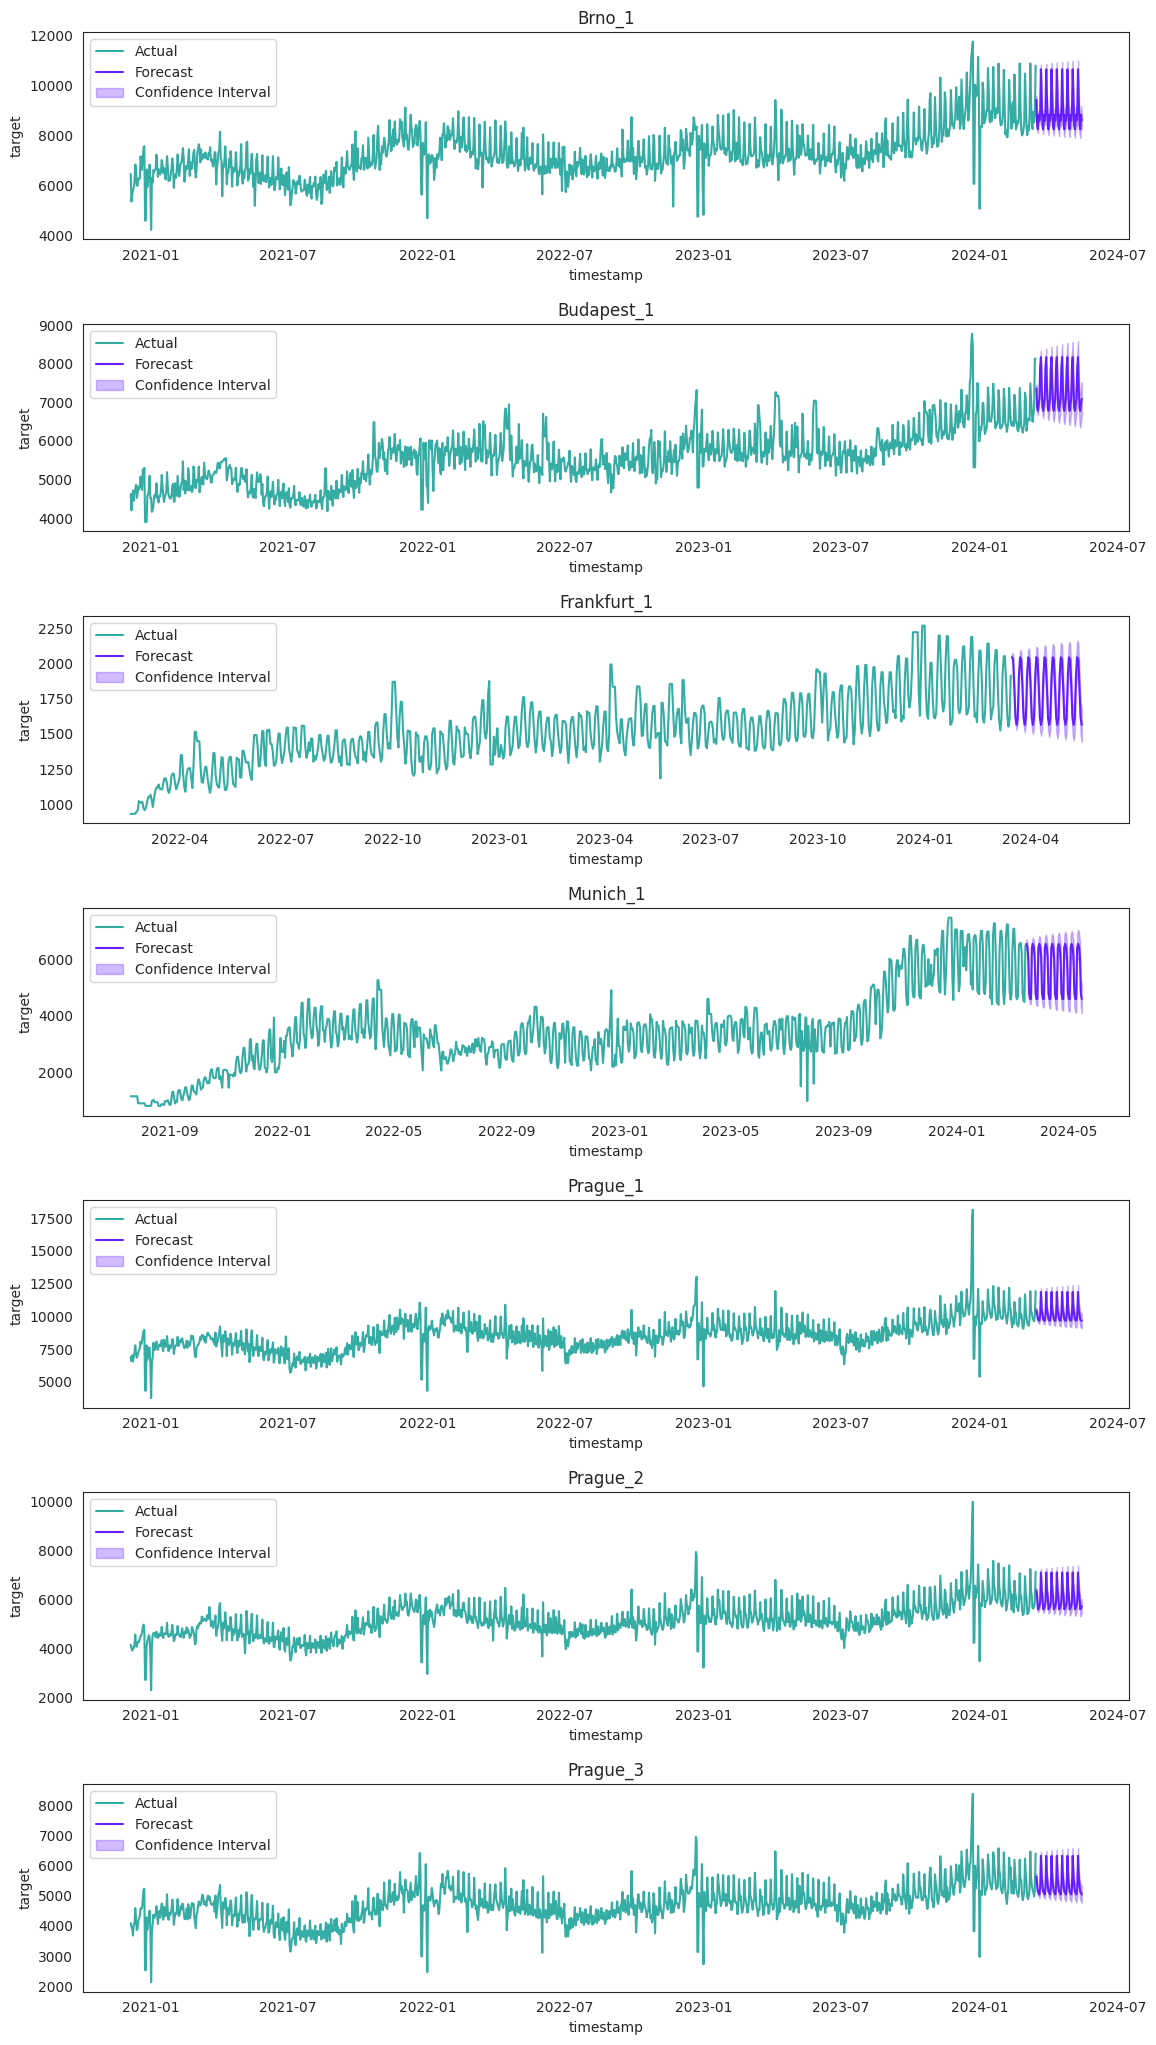

In [22]:
unique_item_ids = predictions['item_id'].unique() if 'item_id' in predictions.columns else predictions.index.get_level_values('item_id').unique()

nrows = len(unique_item_ids)
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
fig.tight_layout(pad=4.0)

if nrows == 1:
    axes = [axes]

for index, item_id in enumerate(unique_item_ids):
    ax = axes[index]
    actual_data = train_data.loc[(train_data.index.get_level_values('item_id') == item_id)]
    forecast_data = predictions.loc[(predictions.index.get_level_values('item_id') == item_id)]

    sns.lineplot(x=actual_data.index.get_level_values('timestamp'), y='target', data=actual_data, ax=ax, label='Actual', color=sns.color_palette('husl')[3])
    sns.lineplot(x=forecast_data.index.get_level_values('timestamp'), y='mean', data=forecast_data, ax=ax, label='Forecast', color='#651FFF')

    lower_quantile = f'{quantile_levels[0]}'
    upper_quantile = f'{quantile_levels[-1]}'
    ax.fill_between(forecast_data.index.get_level_values('timestamp'), forecast_data[lower_quantile], forecast_data[upper_quantile], color='#651FFF', alpha=0.3, label='Confidence Interval')

    ax.set_title(item_id)
    ax.legend()

plt.show()

In [23]:
predictions = predictions.reset_index(drop=False)
predictions['timestamp'] = predictions['timestamp'].astype('str')
predictions['id'] = predictions['item_id'] + '_' + predictions['timestamp']

In [24]:
def get_prediction(row):
    return predictions[predictions['id'] == row['id']]["mean"].values[0]

sub = pd.DataFrame({'id': test_ids, 'orders': 0})
sub['orders'] = sub.apply(get_prediction, axis=1)
sub.to_csv(f'submission.csv', index=False)
sub.head()

,id,orders
0,Prague_1_2024-03-16,10462.194183
1,Prague_1_2024-03-17,10199.807002
2,Prague_1_2024-03-18,9768.126416
3,Prague_1_2024-03-19,9681.516631
4,Prague_1_2024-03-20,9665.083181


In [25]:
shutil.rmtree("AutogluonModels")